# Convolutional Neural Networks

---

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  

The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.

There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

## The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm


---
<a id='step0'></a>
## Step 0: Import Datasets

Make sure that you've downloaded the required human and dog datasets:

**Note: if you are using the Udacity workspace, you *DO NOT* need to re-download these - they can be found in the `/data` folder as noted in the cell below.**

* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dog_images`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [1]:
import os
import wget

def download_and_install(dir_name, url, file_name):
    if not os.path.exists('data/{}'.format(dir_name)):
        print('Downloading dataset in dir data/{}'.format(dir_name))
        wget.download(url, file_name)
        !unzip dogImages.zip
    else:
        print('Found dataset dir data/{}'.format(dir_name))
    
# Check if the dataset is present, otherwise download it

download_and_install(
    'dogImages', 
    'https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip', 
    'data/dogImages.zip')

download_and_install(
    'lfw', 
    'https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip', 
    'data/lfw.zip')


Found dataset dir data/dogImages
Found dataset dir data/lfw


In [2]:
import numpy as np
from glob import glob
import requests

# Get imagenet class names
LABELS_URL = 'https://s3.amazonaws.com/outcome-blog/imagenet/labels.json'
response = requests.get(LABELS_URL)  # Make an HTTP GET request and store the response.
labels = {int(key): value for key, value in response.json().items()}

# load filenames for human and dog images
human_files = np.array(glob("data/lfw/*/*"))
dog_files = np.array(glob("data/dogImages/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

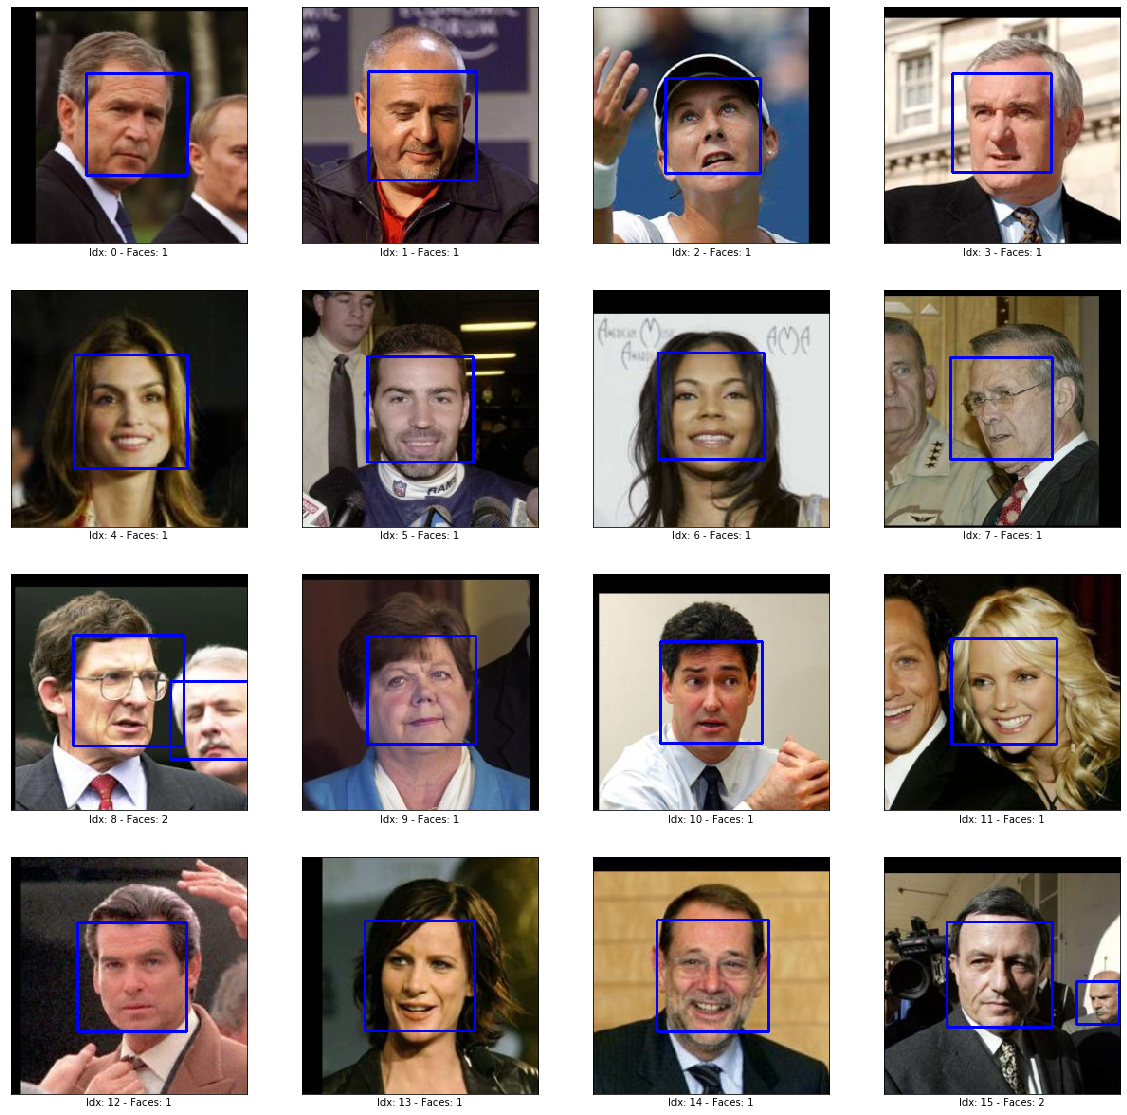

In [3]:
import cv2                
import matplotlib.pyplot as plt   
from random import random
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

def load_random_image():
    
    # load color (BGR) image
    img = cv2.imread(human_files[int(random() * len(human_files))])

    # convert BGR image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # find faces in image
    faces = face_cascade.detectMultiScale(gray)

    # print number of faces detected in the image
    #print('Number of faces detected:', len(faces))

    # get bounding box for each detected face
    for (x,y,w,h) in faces:
        # add bounding box to color image
        cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)

    # convert BGR image to RGB for plotting
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB), len(faces)

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 20))
plot_size=16
for idx in np.arange(plot_size):
    ax = fig.add_subplot(4, plot_size/4, idx+1, xticks=[], yticks=[])
    img, faces = load_random_image()
    plt.xlabel("Idx: {} - Faces: {}".format(idx, faces))
    plt.imshow(img)

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [4]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ Using the *Haar feature-based cascade classifier* model named haarcascade_frontalface_alt, on the first 100 samples of both the dataset, the detection performance are:
- 98% for the `human_files` image set
- 17% for the `dog_files` image set

In [5]:
from tqdm import tqdm

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

#-#-# Do NOT modify the code above this line. #-#-#

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.

def faces_detec_test(images):
    
    faces_detected = 0.0
    total_images = len(images)
    
    for image in images:
        if face_detector(image):
            faces_detected += 1
        
    return faces_detected, total_images
    
print('Cascade \'haarcascade_frontalface_alt\' classifier performance')

faces_detected, total_images = faces_detec_test(human_files_short)
print('  - Humans faces detected: {:.0f}%'.format(faces_detected * 100 / total_images))

dog_detected, total_images = faces_detec_test(dog_files_short)
print('  - Dogs detected: {:.0f}%'.format(dog_detected * 100 / total_images))

Cascade 'haarcascade_frontalface_alt' classifier performance
  - Humans faces detected: 99%
  - Dogs detected: 9%


We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [6]:
### (Optional) 
### TODO: Test performance of anotherface detection algorithm.
### Feel free to use as many code cells as needed.

# Define another pre-trained face detector
face_cascade2 = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt2.xml')

# returns "True" if face is detected in image stored at img_path
def face_detector2(img_path):
    img2 = cv2.imread(img_path)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    faces = face_cascade2.detectMultiScale(gray2)
    return len(faces) > 0

def face_detector2_test(images):
    
    faces_detected = 0.0
    total_images = len(images)
    
    for image in images:
        if face_detector2(image):
            faces_detected += 1
        
    return faces_detected, total_images
    
print('Cascade \'haarcascade_frontalface_alt2\' classifier performance')

faces_detected, total_images = face_detector2_test(human_files_short)
print('  - Humans faces detected: {:.0f}%'.format(faces_detected * 100 / total_images))

dog_detected, total_images = face_detector2_test(dog_files_short)
print('  - Dogs detected: {:.0f}%'.format(dog_detected * 100 / total_images))

Cascade 'haarcascade_frontalface_alt2' classifier performance
  - Humans faces detected: 100%
  - Dogs detected: 16%


__Answer__: Using the *Haar feature-based cascade classifier* model named haarcascade_frontalface_alt2, on the first 100 samples of both the dataset, the detection performance are:
- 100% for the `human_files` image set
- 16% for the `dog_files` image set